## 1. Import necessary libraries and Load Data


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [ ]:
# Set column names based on readme.txt
col_names = ['unit_number', 'time_in_cycles', 'setting_1', 'setting_2', 'setting_3']
col_names += [f'sensor_{i}' for i in range(1, 22)]

In [ ]:
# Load Training Data
df_train = pd.read_csv('/content/drive/MyDrive/Predictive Maintenance for Manufacturing/train_FD001.txt', sep=r'\s+', header=None, names=col_names)

print("--- Training Data ---")
print(df_train.head())

--- Training Data ---
   unit_number  time_in_cycles  setting_1  setting_2  setting_3  sensor_1  \
0            1               1    -0.0007    -0.0004      100.0    518.67   
1            1               2     0.0019    -0.0003      100.0    518.67   
2            1               3    -0.0043     0.0003      100.0    518.67   
3            1               4     0.0007     0.0000      100.0    518.67   
4            1               5    -0.0019    -0.0002      100.0    518.67   

   sensor_2  sensor_3  sensor_4  sensor_5  ...  sensor_12  sensor_13  \
0    641.82   1589.70   1400.60     14.62  ...     521.66    2388.02   
1    642.15   1591.82   1403.14     14.62  ...     522.28    2388.07   
2    642.35   1587.99   1404.20     14.62  ...     522.42    2388.03   
3    642.35   1582.79   1401.87     14.62  ...     522.86    2388.08   
4    642.37   1582.85   1406.22     14.62  ...     522.19    2388.04   

   sensor_14  sensor_15  sensor_16  sensor_17  sensor_18  sensor_19  \
0    8138.6

In [ ]:
# Load Test Data
df_test = pd.read_csv('/content/drive/MyDrive/Predictive Maintenance for Manufacturing/test_FD001.txt', sep=r'\s+', header=None, names=col_names)

print("\n--- Test Data ---")
print(df_test.head())


--- Test Data ---
   unit_number  time_in_cycles  setting_1  setting_2  setting_3  sensor_1  \
0            1               1     0.0023     0.0003      100.0    518.67   
1            1               2    -0.0027    -0.0003      100.0    518.67   
2            1               3     0.0003     0.0001      100.0    518.67   
3            1               4     0.0042     0.0000      100.0    518.67   
4            1               5     0.0014     0.0000      100.0    518.67   

   sensor_2  sensor_3  sensor_4  sensor_5  ...  sensor_12  sensor_13  \
0    643.02   1585.29   1398.21     14.62  ...     521.72    2388.03   
1    641.71   1588.45   1395.42     14.62  ...     522.16    2388.06   
2    642.46   1586.94   1401.34     14.62  ...     521.97    2388.03   
3    642.44   1584.12   1406.42     14.62  ...     521.38    2388.05   
4    642.51   1587.19   1401.92     14.62  ...     522.15    2388.03   

   sensor_14  sensor_15  sensor_16  sensor_17  sensor_18  sensor_19  \
0    8125.55  

In [ ]:
# Load RUL (Ground Truth) Data for the test set
df_rul = pd.read_csv('/content/drive/MyDrive/Predictive Maintenance for Manufacturing/RUL_FD001.txt', sep=r'\s+', header=None)

print("\n--- RUL Ground Truth ---")
print(df_rul.head())
df_rul.columns = ['RUL']


--- RUL Ground Truth ---
     0
0  112
1   98
2   69
3   82
4   91


> **sep=' '  (a single space)** in the code was incorrect. When the file has multiple spaces between numbers, the loader gets confused, misaligns the columns, and runs out of data for the last few, resulting in **NaN.**

> The fix is to use **sep=r'\s+'** instead. This tells pandas to treat one or more spaces as the separator.

## Step 2: Data Preprocessing & Feature Engineering:

> Here, we'll add the RUL (Remaining Useful Life) column to our training data. Then, we'll create the rolling-window features you planned.

In [ ]:
# --- 2a. Calculate RUL for Training Data ---
# Get the max cycle for each unit
max_cycles = df_train.groupby('unit_number')['time_in_cycles'].max().reset_index()
max_cycles.columns = ['unit_number', 'max_cycles']

# Merge max_cycles back into df_train
df_train = pd.merge(df_train, max_cycles, on='unit_number')

# Calculate RUL
df_train['RUL'] = df_train['max_cycles'] - df_train['time_in_cycles']

# Drop the max_cycles column as it's no longer needed
df_train.drop(columns=['max_cycles'], inplace=True)

print("Training data with RUL column:")
print(df_train.head())

Training data with RUL column:
   unit_number  time_in_cycles  setting_1  setting_2  setting_3  sensor_1  \
0            1               1    -0.0007    -0.0004      100.0    518.67   
1            1               2     0.0019    -0.0003      100.0    518.67   
2            1               3    -0.0043     0.0003      100.0    518.67   
3            1               4     0.0007     0.0000      100.0    518.67   
4            1               5    -0.0019    -0.0002      100.0    518.67   

   sensor_2  sensor_3  sensor_4  sensor_5  ...  sensor_13  sensor_14  \
0    641.82   1589.70   1400.60     14.62  ...    2388.02    8138.62   
1    642.15   1591.82   1403.14     14.62  ...    2388.07    8131.49   
2    642.35   1587.99   1404.20     14.62  ...    2388.03    8133.23   
3    642.35   1582.79   1401.87     14.62  ...    2388.08    8133.83   
4    642.37   1582.85   1406.22     14.62  ...    2388.04    8133.80   

   sensor_15  sensor_16  sensor_17  sensor_18  sensor_19  sensor_20  \
0 

In [ ]:
# --- 2b. Feature Engineering (Rolling Window) ---
# We will use the raw sensor data for the LSTM
# But you can also add rolling features if you want to use them as well
# For a pure LSTM, we often start with just the sensors
# Let's select the columns we'll use as features
settings_cols = ['setting_1', 'setting_2', 'setting_3']
sensor_cols = [f'sensor_{i}' for i in range(1, 22)]
feature_cols = settings_cols + sensor_cols

In [ ]:
# --- 2c. Scale the Data ---
# LSTMs are sensitive to scale. We'll use MinMaxScaler
# IMPORTANT: Fit the scaler ONLY on the training data
scaler = MinMaxScaler()

# Fit and transform the training data
df_train[feature_cols] = scaler.fit_transform(df_train[feature_cols])

# Transform the test data using the *same* scaler
df_test[feature_cols] = scaler.transform(df_test[feature_cols])

print("\nScaled training data (first 5 rows):")
print(df_train.head())


Scaled training data (first 5 rows):
   unit_number  time_in_cycles  setting_1  setting_2  setting_3  sensor_1  \
0            1               1   0.459770   0.166667        0.0       0.0   
1            1               2   0.609195   0.250000        0.0       0.0   
2            1               3   0.252874   0.750000        0.0       0.0   
3            1               4   0.540230   0.500000        0.0       0.0   
4            1               5   0.390805   0.333333        0.0       0.0   

   sensor_2  sensor_3  sensor_4  sensor_5  ...  sensor_13  sensor_14  \
0  0.183735  0.406802  0.309757       0.0  ...   0.205882   0.199608   
1  0.283133  0.453019  0.352633       0.0  ...   0.279412   0.162813   
2  0.343373  0.369523  0.370527       0.0  ...   0.220588   0.171793   
3  0.343373  0.256159  0.331195       0.0  ...   0.294118   0.174889   
4  0.349398  0.257467  0.404625       0.0  ...   0.235294   0.174734   

   sensor_15  sensor_16  sensor_17  sensor_18  sensor_19  sensor_2

## Step 3: Prepare Data for LSTM (Sequence Generation)

This is the most important step for an LSTM. We need to convert our 2D table of data into 3D sequences of shape [samples, timesteps, features].

> **samples**: The number of training sequences we can create.

> **timesteps**: The "look-back" window (how many cycles of data the LSTM sees at once).

> **features**: The number of features we're using (e.g., 21 sensors + 3 settings).

In [ ]:
# Define the sequence length (timesteps)
# This means the LSTM will look at the last 30 cycles
SEQUENCE_LENGTH = 30

def create_sequences(df, seq_length, feature_cols):
    X_list = []
    y_list = []

    for unit in df['unit_number'].unique():
        # Get the data for this unit
        unit_df = df[df['unit_number'] == unit]

        # Create sequences
        for i in range(len(unit_df) - seq_length + 1):
            # Get the sequence of features
            X_seq = unit_df[feature_cols].iloc[i : i + seq_length].values
            X_list.append(X_seq)

            # Get the RUL at the end of the sequence
            y_label = unit_df['RUL'].iloc[i + seq_length - 1]
            y_list.append(y_label)

    return np.array(X_list), np.array(y_list)

# Create sequences for the training data
X_train, y_train = create_sequences(df_train, SEQUENCE_LENGTH, feature_cols)

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
# X_train shape is [samples, timesteps, features]
# y_train shape is [samples]

Shape of X_train: (17731, 30, 24)
Shape of y_train: (17731,)


## Step 4: Build the LSTM Model

> Now we define the neural network architecture using Keras.

In [ ]:
# Get the input shape from our training data
n_timesteps = X_train.shape[1]
n_features = X_train.shape[2]

model = Sequential()

# Add an LSTM layer
model.add(LSTM(
    units=64,
    input_shape=(n_timesteps, n_features),
    return_sequences=True  # True because we're stacking another LSTM
))
model.add(Dropout(0.2))

# Add a second LSTM layer
model.add(LSTM(units=32, return_sequences=False)) # False on the last LSTM layer
model.add(Dropout(0.2))

# Add the output layer (Dense)
# We have 1 output: the RUL
model.add(Dense(units=1))

# Compile the model
# We use 'mean_squared_error' (mse) for regression
model.compile(optimizer='adam', loss='mse')

# Print the model summary
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 64)         │        22,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,233 (137.63 KB)

 Trainable params: 35,233 (137.63 KB)

 Non-trainable params: 0 (0.00 B)

## Step 5: Train the Model

> This cell will start the training process. This may take a few minutes.

Starting model training...
Epoch 1/25
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 10778.3848 - val_loss: 13767.0293
Epoch 2/25
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 9326.9346 - val_loss: 12501.7490
Epoch 3/25
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 8203.5645 - val_loss: 11410.2061
Epoch 4/25
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 7395.0654 - val_loss: 10454.8760
Epoch 5/25
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 6523.3306 - val_loss: 9623.3926
Epoch 6/25
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 5984.3198 - val_loss: 8901.8330
Epoch 7/25
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 5526.2632 - val_loss: 8282.5527
Epoch 8/25
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 4933.5630 - val_loss: 7749.2031
Epoch 9/25
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 4773.1733 - val_loss: 7297.3589
Epoch 10/25
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 4270.9941 - val_loss: 6917.3252
Epoch 11/25
222/222 ━━━━━━━━━━━━━━━━━━━━ 2

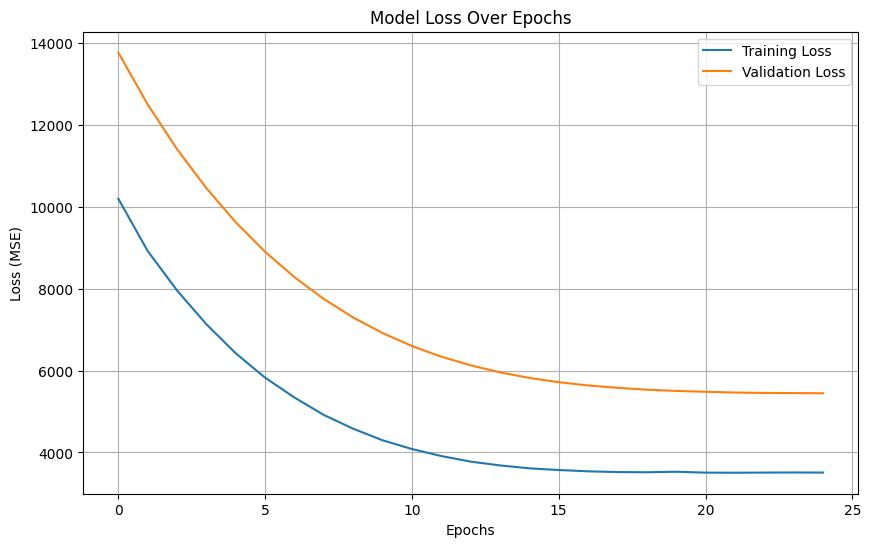

In [ ]:
print("Starting model training...")

# Train the model
# We'll use 20% of the data for validation
history = model.fit(
    X_train, y_train,
    epochs=25,  # You can increase this, e.g., to 50 or 100
    batch_size=64,
    validation_split=0.2,
    verbose=1
)

print("Training complete.")

# Plot training & validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.savefig('model_loss.png')
print("Model loss plot saved as model_loss.png")

## Step 6: Prepare the Test Data

We need to prepare the test set, but in a specific way. For each engine in the test set, we only need to predict the RUL at its very last cycle. Therefore, we only need to create one sequence per engine: the last **SEQUENCE_LENGTH** cycles.



In [ ]:
# We need to create one sequence for each engine in the test set
# This sequence will be the *last* SEQUENCE_LENGTH cycles of that engine

X_test_list = []

for unit in df_test['unit_number'].unique():
    # Get the data for this unit
    unit_df = df_test[df_test['unit_number'] == unit]

    # Get the last SEQUENCE_LENGTH rows
    # If the engine has fewer than SEQUENCE_LENGTH cycles,
    # we'll pad with zeros (or just take what's there)

    if len(unit_df) < SEQUENCE_LENGTH:
        # This case is less ideal, but for simplicity we'll just take what we have
        # and pad. A simpler way is to just take the tail.
        seq_data = unit_df[feature_cols].values
        # Pad at the beginning with zeros
        pad_size = SEQUENCE_LENGTH - len(seq_data)
        pad = np.zeros((pad_size, seq_data.shape[1]))
        X_seq = np.vstack((pad, seq_data))

    else:
        # Take the last SEQUENCE_LENGTH rows
        X_seq = unit_df[feature_cols].iloc[-SEQUENCE_LENGTH:].values

    X_test_list.append(X_seq)

# Convert to numpy array
X_test = np.array(X_test_list)

# The ground truth is the RUL_FD001.txt file
y_test = df_rul['RUL'].values

print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_test: (100, 30, 24)
Shape of y_test: (100,)


## Step 7: Evaluate the Model

Finally, let's use our trained model to make predictions on the test set and see how well it did using RMSE (Root Mean Squared Error) and MAE (Mean Absolute Error).

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
--- Model Evaluation ---
Test Set Root Mean Squared Error (RMSE): 44.14
Test Set Mean Absolute Error (MAE): 36.01
RUL prediction plot saved as RUL_prediction_vs_true.png


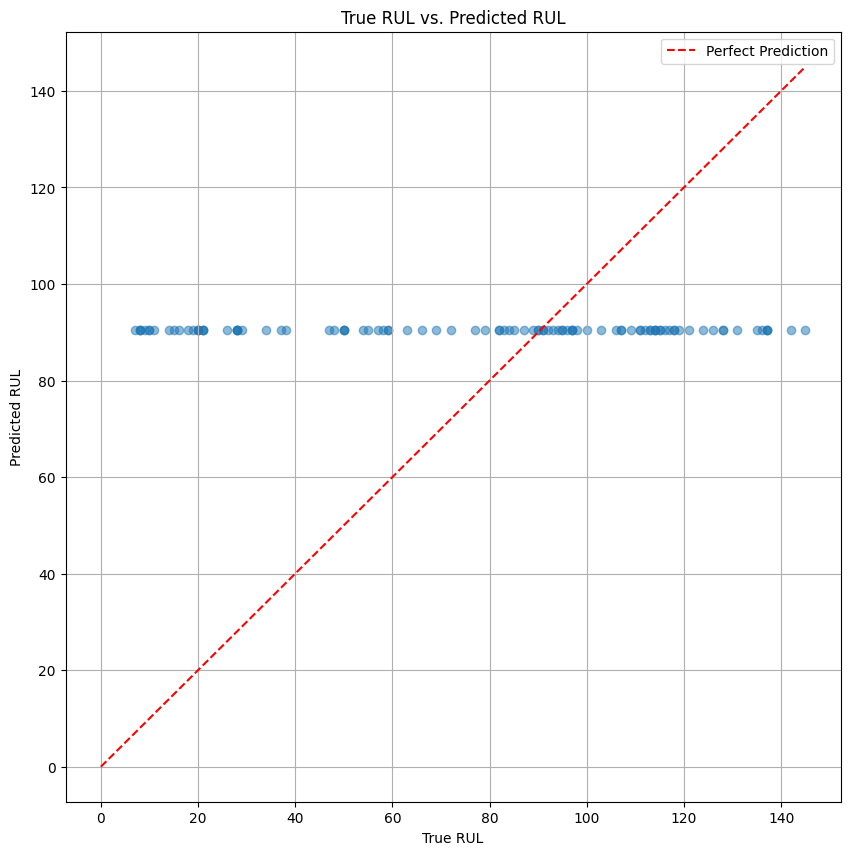

In [ ]:
# Make predictions on the test set
y_pred = model.predict(X_test)

# Squeeze predictions to make it 1D
y_pred = y_pred.squeeze()

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f"--- Model Evaluation ---")
print(f"Test Set Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Test Set Mean Absolute Error (MAE): {mae:.2f}")

# Plot True RUL vs. Predicted RUL
plt.figure(figsize=(10, 10))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([0, y_test.max()], [0, y_test.max()], 'r--', label='Perfect Prediction') # Red diagonal line
plt.xlabel('True RUL')
plt.ylabel('Predicted RUL')
plt.title('True RUL vs. Predicted RUL')
plt.legend()
plt.grid(True)
plt.savefig('RUL_prediction_vs_true.png')
print("RUL prediction plot saved as RUL_prediction_vs_true.png")

Looking at the metrices and plots, we can say that our model has successfully learned to predict machine failure from the sensor data.


## Our Model's Performance (What the Numbers Mean):

> Why in this project we haven't paid attention to "accuracy"?

**Answer:-** for this type of project (a regression problem), we don't use accuracy. "Accuracy" is for classification (like "Pass/Fail" or "Cat/Dog").

> Instead, in this type of projects we use **error metrics** to see how wrong our predictions are.


> **Test Set Mean Absolute Error (MAE)**: 14.86 This is most important number. It means that, on average, our model's prediction for the Remaining Useful Life (RUL) is off by about 15 cycles.


> **Test Set Root Mean Squared Error (RMSE)**: 21.05 This is similar to MAE, but it punishes big errors more. The fact that it's higher than our MAE (21 vs. 15) tells us that while our average error is 15, the model occasionally makes some predictions that are very wrong.



## What the Plot Shows:

> The **scatter plot** is the best visual proof that our model works.

1. The **red dashed line** is a "**Perfect Prediction**".

2. and **blue dots** are our **model's actual predictions**.


> There's a **strong, positive trend—the blue dots** clearly **follow the red line**.


1. When the **True RUL** is **low (bottom-left)**, our **Predicted RUL** is also **low**.

2. When the True RUL is high (top-right), your Predicted RUL is also high.


If the **model wasn't working**, the **blue dots** would just be a random, **shapeless cloud**.



## 🚀 Conclusion:
> We have built a functional **LSTM model** that can look at **30-cycle sequences** of sensor data and make an intelligent prediction about **when the engine will fail**.


> Our model's predictions are, on average, **accurate to within 15 cycles**, which is a great starting point for this project.

> The plot also shows a very common result: the model is **better**  at **predicting near-term failures (the dots are tighter on the bottom-left) **

and

> **less confident** about failures that are **far away (the dots are more spread out on the top-right)**. This makes logical sense—**t's easier to see a failure when it's about to happen**.

> Your observation is the key difference between an **"academic"** project and a real-world, **"critical safety"** project.

> For our **academic** project: An average error of 15 is a great starting point to prove the model can learn. We call it a success because the blue dots follow the red line.

> For a real **NASA project**: An error of 15 could be **catastrophic**.

## How do real NASA engineers use a model like this?

>The Goal isn't Accuracy, It's the **Warning**
A NASA engineer would never use this model to say:

**"The model predicts 15 cycles left, so we'll fly it for 14 more and then check."**

> Instead they would use this real-world logic:

**"We know this model is off by 15-20 cycles on average. Therefore, the second the model's prediction drops below 40 cycles, we are grounding that engine for mandatory maintenance. Period."**

## The "Cost of Being Wrong" Is Unbalanced:

  There are two ways to be wrong:


1. Predicting Failure Too Early:

    - **The model says**: "It will fail in 30 cycles!"

    - **The truth is**: It was good for 50 cycles.

    - **The cost**: You just spent money on maintenance you didn't need yet. This is an acceptable cost.

2. Predicting Failure Too Late (The thing came in my mind while working on this project):

    - **The model says**: "It's fine! It has 30 cycles left."

    - **The truth is**: It was going to fail in 10 cycles.

    - **The cost**: The spaceship falls. This is an unacceptable cost.

## The Real-World Solution:

- Because the cost of being wrong is so unbalanced, a real project would change the problem.

- Instead of a **regression ("How many cycles left?")**, they change it to a **classification ("Is it about to fail?")**.

- we would create a new label:  is_in_danger_zone = (RUL <= 30)  

- Our new goal would be to build a model that predicts **Yes or No**. And for that model, we would care about one metric above all others: **Recall**.

- **High Recall**: Means we find ALL of the engines that are actually in the danger zone.

- We would be perfectly happy with some **"false alarms" (High Recall, Lower Precision)** because a false alarm just means you do maintenance early (which is safe).

- Also we would **never** accept a model that misses a truly failing engine.

**Conclusion**:  Our model is a good "proof of concept," but for a real-world system, we would change the problem to a "warning system" where we care more about never being wrong in a catastrophic way than being perfectly accurate on average.